In [4]:
import pandas as pd
import numpy as np

In [12]:
df = pd.read_parquet("../Data_cleaned/metadatosgoogle/merged_reviews_clean.parquet")

In [6]:
df.head(5)

,user_id,name,time,rating,text,pics,resp,gmap_id
0,113068308323231430437,Edwin Ashurst,1537195868022,5,The salads were lackluster though with well wr...,null,null,0x8894b5a7a7909725:0xe4687299fd288188
1,105941553219163737304,Douglas Gummere,1537402367631,1,"Love this place. Great little restaurant, with...",null,null,0x8894b5a7a7909725:0xe4687299fd288188
2,109857700811373231502,David Powell,1534936396392,5,A classy restaurant to match the charm of the ...,null,null,0x8894b5a7a7909725:0xe4687299fd288188
3,114737748503783343160,Hillary Hutchins,1555464332274,5,Great atmosphere and good food,null,null,0x8894b5a7a7909725:0xe4687299fd288188
4,108987048547659250890,Ajay patel,1558392170993,5,Good food,null,null,0x8894b5a7a7909725:0xe4687299fd288188


In [7]:
# Verificar el tamaño y los tipos de datos
print(df.shape)
print(df.dtypes)

(2435719, 8)
user_id    object
name       object
time        int64
rating      int64
text       object
pics       object
resp       object
gmap_id    object
dtype: object


# Diccionario de Datos de Reviews

| Columna   | Tipo de Dato | Descripción                                                                                     |
|-----------|--------------|-------------------------------------------------------------------------------------------------|
| `user_id` | `object`     | Identificador único del usuario que realizó la reseña.                                         |
| `name`    | `object`     | Nombre del usuario que realizó la reseña.                                                      |
| `time`    | `int64`      | Timestamp en milisegundos indicando cuándo se realizó la reseña.                               |
| `rating`  | `int64`      | Calificación dada por el usuario al restaurante (rango típico: 1-5).                           |
| `text`    | `object`     | Texto descriptivo de la reseña, con los comentarios del usuario sobre su experiencia.          |
| `pics`    | `object`     | URL o lista de imágenes asociadas con la reseña (si las hay).                                  |
| `resp`    | `object`     | Respuesta del restaurante a la reseña (si la hay).                                             |
| `gmap_id` | `object`     | Identificador único del restaurante asociado con la reseña en Google Maps.                    |

**Dimensiones del Dataset:**  
- Filas: 2,435,719  
- Columnas: 8  


In [24]:
# Reemplazar strings 'null' y valores vacíos por NaN
df['pics'] = df['pics'].replace(['null', ''], np.nan)
df['resp'] = df['resp'].replace(['null', ''], np.nan)

# Verificar valores nulos nuevamente
print(f"Valores nulos en 'pics': {df['pics'].isnull().sum()}")
print(f"Valores nulos en 'resp': {df['resp'].isnull().sum()}")


Valores nulos en 'pics': 2345664
Valores nulos en 'resp': 2208646


In [25]:
print(df.isnull().sum())

user_id              0
name                 0
time                 0
rating               0
text            984739
pics           2345664
resp           2208646
gmap_id              0
text_length          0
date                 0
dtype: int64


## Conclusión sobre los Datos Nulos

- **`text` (40.43% nulo):**  
  La ausencia de texto en una proporción significativa de las reseñas limita los análisis basados en contenido (como análisis de sentimiento). Podríamos:
  - Mantener las filas con texto para análisis específicos.
  - Usar las demás columnas (rating, fecha, etc.) para otras evaluaciones.

- **`pics` (96.30% nulo):**  
  La mayoría de las reseñas no contienen imágenes, lo cual es común. Dado su bajo impacto, podemos ignorar esta columna para análisis iniciales o excluirla directamente.

- **`resp` (90.68% nulo):**  
  La mayoría de las reseñas no tienen respuesta del restaurante. Esto podría usarse para evaluar el compromiso de los locales que sí responden, pero no afecta análisis generales.

- **Acción General:**  
  - Para columnas críticas (`text`), filtrar o imputar según el análisis.
  - Para columnas como `pics` y `resp`, considerarlas opcionales o excluirlas según el caso.


In [15]:
print(df.duplicated(subset=['user_id', 'gmap_id', 'time']).sum())

141


141 duplicados es una cantidad despreciable para la cantidad de datos que tenemos, no deberían generar problema por lo que a priori no sería una necesidad resolverlos.

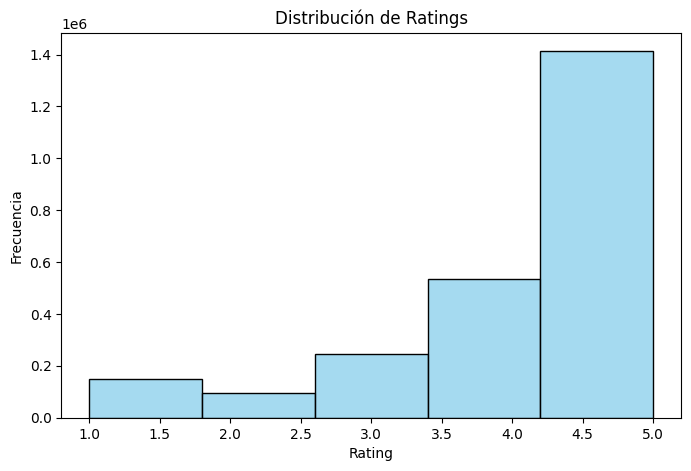

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.histplot(df['rating'], bins=5, kde=False, color='skyblue')
plt.title('Distribución de Ratings')
plt.xlabel('Rating')
plt.ylabel('Frecuencia')
plt.show()


## Distribución de Ratings

- **Descripción General:**
  - La mayoría de las reseñas tienen calificaciones altas, con una concentración significativa en el valor 5.
  - Los ratings de 4 a 4.5 también son comunes, lo que refuerza la tendencia hacia evaluaciones positivas.

- **Observaciones:**
  - Las calificaciones bajas (1 y 2) son mucho menos frecuentes, lo que sugiere que los usuarios tienden a dejar comentarios positivos más que negativos.
  - Existe un sesgo claro hacia los ratings altos, lo que podría deberse a la satisfacción general de los clientes o a que los usuarios insatisfechos dejan reseñas con menor frecuencia.

- **Implicaciones:**
  - Este sesgo hacia calificaciones altas puede influir en los modelos de recomendación, ya que podría ser necesario normalizar o ajustar los datos para reducir su impacto.
  - Sería interesante analizar los textos de reseñas negativas (1-2) para entender los motivos de las bajas calificaciones y compararlos con los positivos.


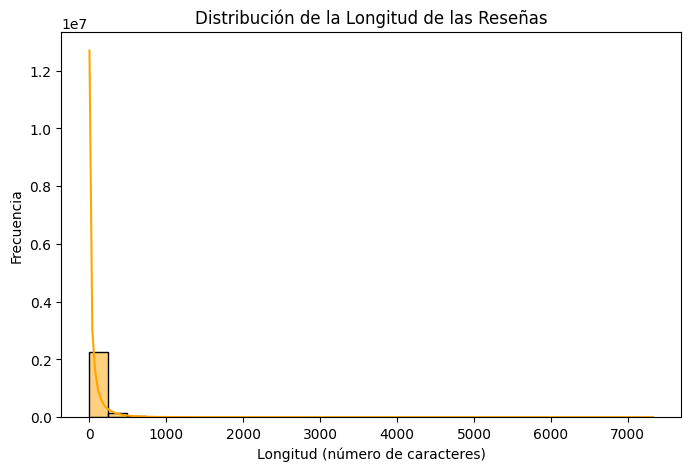

count    2.435719e+06
mean     7.452398e+01
std      1.549773e+02
min      0.000000e+00
25%      0.000000e+00
50%      2.100000e+01
75%      8.200000e+01
max      7.329000e+03
Name: text_length, dtype: float64


In [18]:
df['text_length'] = df['text'].fillna('').apply(len)

plt.figure(figsize=(8, 5))
sns.histplot(df['text_length'], bins=30, kde=True, color='orange')
plt.title('Distribución de la Longitud de las Reseñas')
plt.xlabel('Longitud (número de caracteres)')
plt.ylabel('Frecuencia')
plt.show()

# Resumen estadístico de la longitud
print(df['text_length'].describe())


## Distribución de la Longitud de las Reseñas

- **Observaciones:**
  - La mayoría de las reseñas son muy cortas (menos de 200 caracteres).
  - Existen pocas reseñas largas, lo que indica que la mayoría de usuarios dejan comentarios breves.

- **Implicaciones:**
  - Las reseñas largas pueden contener información más detallada y valiosa para análisis de sentimiento.


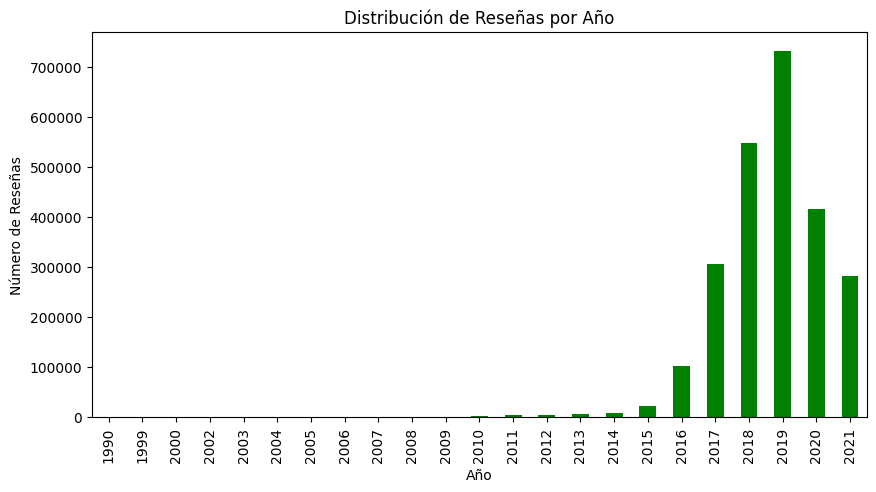

In [19]:
df['date'] = pd.to_datetime(df['time'], unit='ms')

plt.figure(figsize=(10, 5))
df['date'].dt.year.value_counts().sort_index().plot(kind='bar', color='green')
plt.title('Distribución de Reseñas por Año')
plt.xlabel('Año')
plt.ylabel('Número de Reseñas')
plt.show()

## Distribución de Reseñas por Año

- **Observaciones:**
  - Las reseñas aumentaron significativamente desde 2016, alcanzando su punto máximo en 2019.
  - Hay una caída visible en 2020, probablemente debido al impacto de la pandemia.

- **Implicaciones:**
  - Este crecimiento sugiere mayor adopción de plataformas de reseñas en los últimos años.
  - La caída en 2020 podría influir en tendencias y análisis relacionados con la actividad en restaurantes.

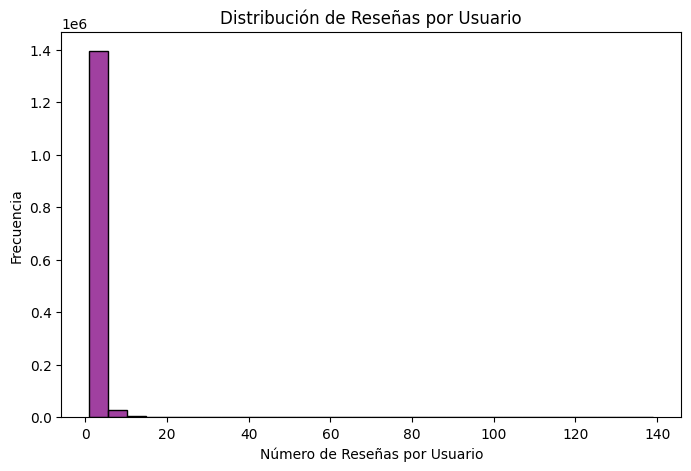

In [21]:
user_reviews_count = df['user_id'].value_counts()

plt.figure(figsize=(8, 5))
sns.histplot(user_reviews_count, bins=30, kde=False, color='purple')
plt.title('Distribución de Reseñas por Usuario')
plt.xlabel('Número de Reseñas por Usuario')
plt.ylabel('Frecuencia')
plt.show()


## Distribución de Reseñas por Usuario

- **Observaciones:**
  - La mayoría de los usuarios publican solo una reseña.
  - Un pequeño grupo de usuarios publica muchas reseñas (superusuarios).

- **Implicaciones:**
  - Los superusuarios podrían tener un peso desproporcionado en los análisis de tendencias y modelos de recomendación.
